In [1]:
import torch
from torch import nn  #nn contains all PyTorch's building blocks for neural network
import numpy as np
import matplotlib.pyplot as plt


## Creating a Simple Dataset

In [2]:
weight = 0.6
bias = 0.4


start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.4000],
         [0.4120],
         [0.4240],
         [0.4360],
         [0.4480],
         [0.4600],
         [0.4720],
         [0.4840],
         [0.4960],
         [0.5080]]))

In [3]:
len(X), len(y)

(50, 50)

## Splitting the Data into Training and Test Sets

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualizing our Data

In [5]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):

  # Plotting Train and Test Data and comparing Predictions
  plt.figure(figsize=(10,7))

  # Plotting Training Data in Blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # Plotting Test Data in Green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend()

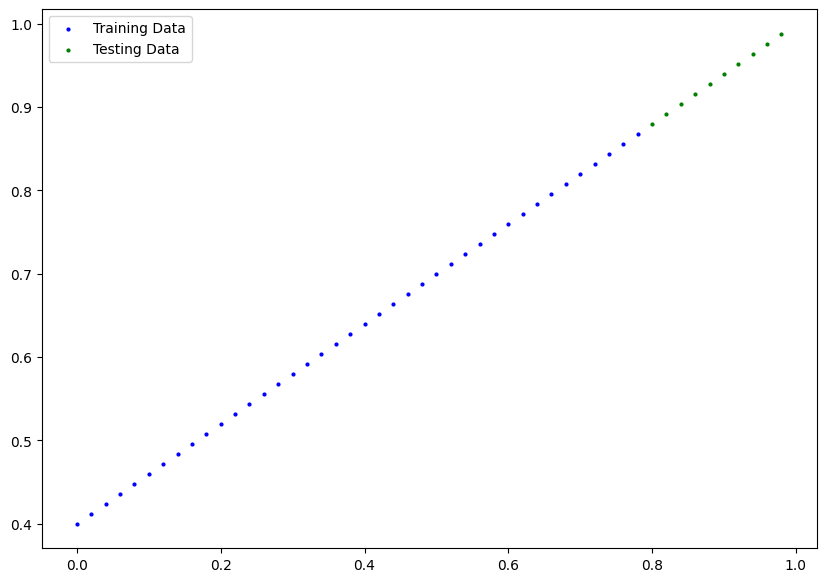

In [6]:
plot_predictions()

## Building First PyTorch Model

- `nn.Module` is Base Class for all neural network Modules

- Your models should also subclass this class

- " -> torch.Tensor" is a type hint. It tells the reader "x" should be `torch.Tensor` and the result will also be `torch.Tensor`

- `requires_grad = True` means PyTorch will track the gradients of this specific Parameter for use with `torch.autograd` and gradient descent.

- Any subclass of `nn.Modules` needs to override `forward()` method means when using `nn.Modules`, we need to define `forward()` method.

In [7]:
# Creating Linear Regression Model Class
class LinearRegressionModel(nn.Module): # Almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()

    # Starting with a Random Value (1) and trying to adjust it to the ideal weight and bias
    # By Default, requires_grad = True and dtype is Float, but still defined below explicitly
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define the Computation in the Model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # Linear Regression Formula

## Checking the contents of PyTorch model

In [8]:
# Creating the Random Seed
torch.manual_seed(42)

# Creating the instance of the LR Model Class
model_0 = LinearRegressionModel()

# Checking out the Parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# Listing the Named Parameters for no confusion
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making Predictions

In [10]:
# This method of predictions keeps the Gradient tracking on.
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [11]:
# This inference mode turns off the gradient tracking.
with torch.inference_mode():
  y_preds = model_0(X_test)

'''
You can also use torch.no_grad(), however torch.inference_mode() is more common

with torch.no_grad():
  y_preds = model_0(X_test)

'''

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
y_test

tensor([[0.8800],
        [0.8920],
        [0.9040],
        [0.9160],
        [0.9280],
        [0.9400],
        [0.9520],
        [0.9640],
        [0.9760],
        [0.9880]])

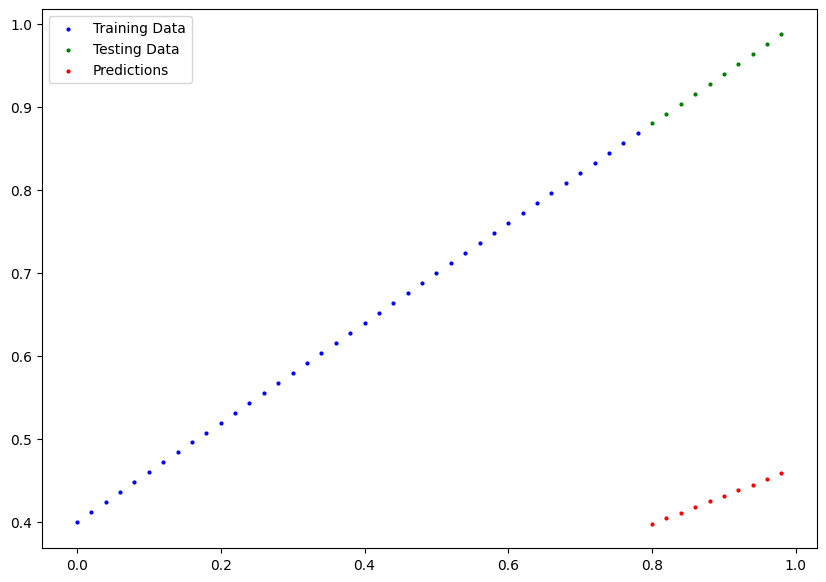

In [13]:
plot_predictions(predictions=y_preds)

## Training a Model

Things we need for training -

- **Loss Function**
- **Optimizer**

In [14]:
# Setup a Loss Function
loss_fn = nn.L1Loss()

# Setup an Optimizer (Stochastic Gradient Descent)
# lr is the most important hyperparameter you can set
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [15]:
#  An epoch is one loop through the data...
epochs = 100

epoch_count = []
train_loss = []
test_losses = []

# Looping through the Data
for epoch in range(epochs):

  # Setting the model to training mode
  model_0.train() # train mode in pytorch sets all parameters that require gradients to require gradients

  # Forward Pass
  y_preds = model_0(X_train)

  # Calculating the Loss
  loss = loss_fn(y_preds, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Performing Backpropogation on loss
  loss.backward()

  # Step the Optimizer (Perform Gradient Descent)
  optimizer.step()
  '''

  By Default, how the optimizer changes will accumulate through the loop so, we have to zero them above for the next iteration of the loop to start fresh
  Eg - if the optimizer changes the value by 1, then it goes through the loop again, so we have to zero it for the next iteration to start fresh in every iteration

  '''

  # Testing
  model_0.eval() # turns off gradient tracking and sets the model to evaluation mode

  # Turns off Gradient Tracking for evaluation / testing
  with torch.inference_mode():

    # Do the Forward Pass fot Test Set
    test_preds = model_0(X_test)

    # Calculating the Loss
    test_loss = loss_fn(test_preds, y_test)

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss.append(loss.detach().numpy())
      test_losses.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
      print(model_0.state_dict())

Epoch: 0 | Loss: 0.37388134002685547 | Test Loss: 0.4920651316642761
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 | Loss: 0.2586713433265686 | Test Loss: 0.3573552668094635
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 | Loss: 0.1434614360332489 | Test Loss: 0.2226453274488449
OrderedDict({'weights': tensor([0.4186]), 'bias': tensor([0.3388])})
Epoch: 30 | Loss: 0.03848728537559509 | Test Loss: 0.09741605818271637
OrderedDict({'weights': tensor([0.4571]), 'bias': tensor([0.4298])})
Epoch: 40 | Loss: 0.023863982409238815 | Test Loss: 0.05760536342859268
OrderedDict({'weights': tensor([0.4827]), 'bias': tensor([0.4468])})
Epoch: 50 | Loss: 0.02031884901225567 | Test Loss: 0.04659420996904373
OrderedDict({'weights': tensor([0.5007]), 'bias': tensor([0.4418])})
Epoch: 60 | Loss: 0.01688215509057045 | Test Loss: 0.039008546620607376
OrderedDict({'weights': tensor([0.5176]), 'bias': tensor([0.4343])})
Epoch: 70 | Loss: 0.0134

In [16]:
# 100th (99) epoch output
model_0.state_dict()

OrderedDict([('weights', tensor([0.5843])), ('bias', tensor([0.4063]))])

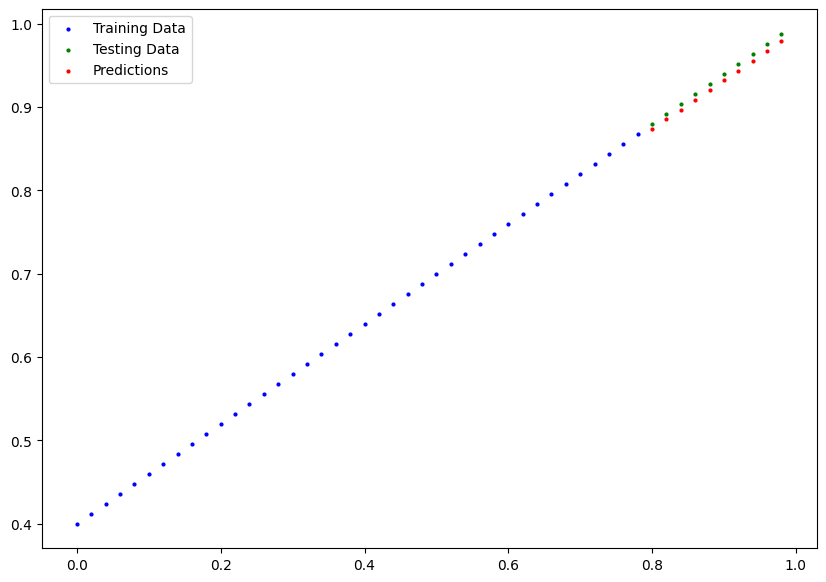

In [17]:
# We can plot this matplotlib chart on test as gradient tracking is off
plot_predictions(predictions=test_preds)

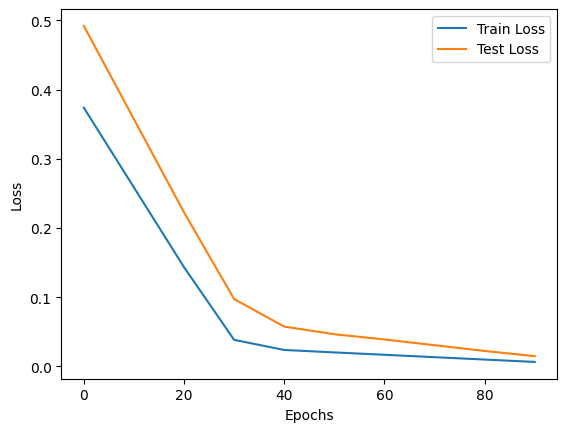

In [18]:
# Plotting the Loss Curve
plt.plot(epoch_count, train_loss, label="Train Loss")
plt.plot(epoch_count, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Saving and Loading a PyTorch Model
- `torch.save()` - allows you to save a PyTorch object in Python's pickle format
- `torch.load()` - allows you to load a saved PyTorch object.
- `torch.nn.Module.load_state_dict()` - allows to load a model's savd dictionary

In [20]:
# Saving a PyTorch Model
from pathlib import Path

# Creating Model's Directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Creating Model's Save Path
# A common PyTorch convention is to save models using either .pt or .pth extension
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Till here, pnly Model's Path is created, no model is saved yet.
MODEL_SAVE_PATH

# Saving a Model
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)


In [24]:
# Loading a Model
# We have to create new instance of our model class to load in a saved state_dict
loaded_model_0 = LinearRegressionModel()

# Loading the saved state_dict of model_0 (This will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [25]:
# Same values in new instance as model_0 parameter's value
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5843])), ('bias', tensor([0.4063]))])